In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Этап 1: Предобработка данных

In [4]:
# Анализ качества данных: пропуски и аномалии

missing_pct = df.isnull().mean() * 100
print("\n[1] АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("-" * 70)
print(f"{'Признак':<20} {'Процент пропусков':<20} {'Статус':<20}")
print("-" * 70)
all_missing = True
for column, pct in missing_pct.items():
    status = "✓ Нет пропусков" if pct == 0 else f"⚠ {pct:.2f}% пропусков"
    print(f"{column:<20} {pct:>18.2f}% {status:<20}")
    if pct > 0:
        all_missing = False
print("-" * 70)
if all_missing:
    print("✓ Все признаки не содержат пропущенных значений")
print()

numerical_features = df.select_dtypes(include='number').columns

def detect_outliers(column_data):
    q1 = column_data.quantile(0.25)
    q3 = column_data.quantile(0.75)
    iqr = q3 - q1
    min_val = q1 - 1.5 * iqr
    max_val = q3 + 1.5 * iqr
    outlier_count = ((column_data < min_val) | (column_data > max_val)).sum()
    return outlier_count, min_val, max_val

outlier_stats = {}
print("[2] АНАЛИЗ ВЫБРОСОВ (метод IQR)")
print("-" * 70)
print(f"{'Признак':<15} {'Выбросов':<12} {'Нижняя граница':<18} {'Верхняя граница':<18}")
print("-" * 70)
for feature in numerical_features:
    count, min_bound, max_bound = detect_outliers(df[feature])
    outlier_stats[feature] = count
    print(f"{feature:<15} {count:>10} {min_bound:>16.2f} {max_bound:>16.2f}")
print("-" * 70)
total_outliers = sum(outlier_stats.values())
print(f"Всего выбросов обнаружено: {total_outliers}")
print()

print("[3] ОБРАБОТКА ВЫБРОСОВ")
print("-" * 70)
print("Применяется метод обрезки (clipping) к граничным значениям...")
for feature in numerical_features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    min_bound = q1 - 1.5 * iqr
    max_bound = q3 + 1.5 * iqr
    df[feature] = df[feature].clip(lower=min_bound, upper=max_bound)
print("✓ Выбросы обработаны")
print()

print("[4] КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("-" * 70)
cat_features = df.select_dtypes(include=['object', 'category']).columns
print(f"{'Признак':<20} {'Тип':<25} {'Количество уровней':<20}")
print("-" * 70)
for feature in cat_features:
    n_unique = df[feature].nunique()
    feature_type = "Бинарный" if n_unique == 2 else "Мультиклассовый"
    print(f"{feature:<20} {feature_type:<25} {n_unique:>18}")
print("-" * 70)

binary_features = ['sex', 'smoker']
multiclass_features = ['region']

for feature in multiclass_features:
    unique_values = df[feature].dropna().unique()
    df = pd.get_dummies(df, columns=[feature], dtype=int)
    for val in unique_values:
        df[f'{feature}_{val}'] = df[f'{feature}_{val}'].astype(int)

print("\n[5] СХЕМА КОДИРОВАНИЯ БИНАРНЫХ ПРИЗНАКОВ")
print("-" * 70)
for feature in binary_features:
    unique_values = df[feature].dropna().unique()
    encoding_dict = {unique_values[0]: 0, unique_values[1]: 1}
    print(f"{feature}:")
    for key, value in encoding_dict.items():
        print(f"  '{key}' → {value}")
    print()
    df[feature] = df[feature].map(encoding_dict)

print()


[1] АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
----------------------------------------------------------------------
Признак              Процент пропусков    Статус              
----------------------------------------------------------------------
age                                0.00% ✓ Нет пропусков     
sex                                0.00% ✓ Нет пропусков     
bmi                                0.00% ✓ Нет пропусков     
children                           0.00% ✓ Нет пропусков     
smoker                             0.00% ✓ Нет пропусков     
region                             0.00% ✓ Нет пропусков     
charges                            0.00% ✓ Нет пропусков     
----------------------------------------------------------------------
✓ Все признаки не содержат пропущенных значений

[2] АНАЛИЗ ВЫБРОСОВ (метод IQR)
----------------------------------------------------------------------
Признак         Выбросов     Нижняя граница     Верхняя граница   
--------------------------------------

**Анализ результатов предобработки:**

Проверка данных показала полное отсутствие пропущенных значений во всех признаках, что исключает необходимость в процедурах заполнения пропусков.

При анализе числовых признаков были выявлены экстремальные значения в некоторых переменных. Учитывая, что дальнейшая работа предполагает построение регрессионных моделей, такие аномалии могут искажать процесс обучения и снижать качество прогнозирования. В связи с этим применен метод ограничения (winsorization) - все значения, выходящие за границы, определенные по правилу межквартильного размаха, заменены на соответствующие пороговые значения.

Категориальные переменные представлены тремя признаками: `sex` и `smoker` имеют два уровня, `region` - четыре уровня.
Для бинарных переменных выполнено числовое кодирование (0/1), а для `region` применено разложение в фиктивные переменные (dummy-кодирование), поскольку данная переменная не имеет естественной упорядоченности категорий.

In [5]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,0,16884.92400,0,0,0,1
1,18,1,33.770,1,1,1725.55230,0,0,1,0
2,28,1,33.000,3,1,4449.46200,0,0,1,0
3,33,1,22.705,0,1,21984.47061,0,1,0,0
4,32,1,28.880,0,1,3866.85520,0,1,0,0


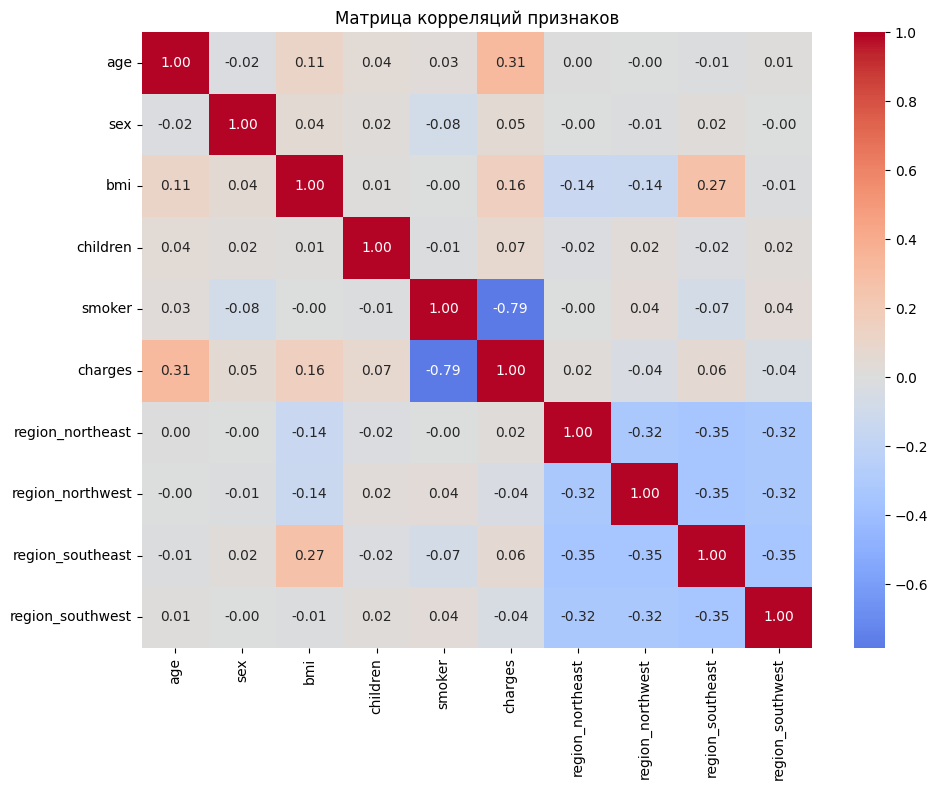

In [6]:
# Анализ корреляций между признаками

corr_matrix = df.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Матрица корреляций признаков")
plt.tight_layout()
plt.show()

**Анализ корреляционной структуры:**

Принято считать, что сильная линейная связь между переменными начинается с коэффициента корреляции по модулю не менее 0.8. В исследуемом датасете подобная зависимость обнаружена исключительно между зависимой переменной `charges` и предиктором `smoker`. Такая ситуация является нормальной и даже предпочтительной, поскольку отражает важную связь между объясняющей и объясняемой переменными.

## Этап 2: Построение модели линейной регрессии

### Метод наименьших квадратов (аналитическое решение)

Математическая модель: $$ f(x, w) = \sum_{i=1}^{n} w_i x_i = Xw $$

Целевая функция (MSE): $$ L(w) = \sum_{i=1}^{m} (f(x_i, w) - y_i)^2 = ||Xw - y||^2 \rightarrow \min_{w} $$

Вычисление градиента: $$ \nabla_w L = 2X^T(Xw-y) $$

Приравнивая градиент к нулю для нахождения минимума:
$$
2X^T(Xw-y) = 0
$$

$$
X^TXw = X^Ty
$$

Оптимальные веса:
$$
w^* = (X^TX)^{-1}X^Ty
$$

In [7]:
target = df['charges'].values
features_raw = df.drop(columns=['charges']).values

X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    features_raw, target, test_size=0.2, random_state=42
)

normalizer = StandardScaler()
X_tr_norm = normalizer.fit_transform(X_tr_raw)
X_te_norm = normalizer.transform(X_te_raw)

# Добавление столбца единиц для свободного члена
X_tr = np.column_stack([np.ones(X_tr_norm.shape[0]), X_tr_norm])
X_te = np.column_stack([np.ones(X_te_norm.shape[0]), X_te_norm])

# Вычисление нормальных уравнений
X_transpose_X = X_tr.T @ X_tr
X_transpose_y = X_tr.T @ y_tr

# Проверка на вырожденность матрицы
if np.linalg.matrix_rank(X_transpose_X) == X_transpose_X.shape[0]:
    weights_ols = np.linalg.solve(X_transpose_X, X_transpose_y)
else:
    weights_ols = np.linalg.pinv(X_tr) @ y_tr

print("=" * 60)
print("ОПТИМАЛЬНЫЕ ВЕСА МОДЕЛИ (Метод наименьших квадратов)")
print("=" * 60)
print(f"{'Индекс':<10} {'Коэффициент':<20} {'Значение':<20}")
print("-" * 60)
for idx, weight in enumerate(weights_ols):
    print(f"w[{idx:2d}]     {'':<15} {weight:>18.6f}")
print("=" * 60)
print()

ОПТИМАЛЬНЫЕ ВЕСА МОДЕЛИ (Метод наименьших квадратов)
Индекс     Коэффициент          Значение            
------------------------------------------------------------
w[ 0]                           12566.865616
w[ 1]                            3185.039012
w[ 2]                             -63.903919
w[ 3]                            1377.163997
w[ 4]                             464.550705
w[ 5]                           -8017.685110
w[ 6]                             192.136220
w[ 7]                              33.133063
w[ 8]                             -82.422527
w[ 9]                            -141.328460



### Итеративный метод оптимизации (градиентный спуск)

Инициализация: $w^{(0)}$ - начальный вектор весов  
Параметр обучения: $\eta$ - скорость обучения (learning rate)

Итеративное обновление весов:
$$w^{(k+1)} = w^{(k)} - \eta \cdot \nabla_w L|_{w=w^{(k)}}$$

Критерии остановки алгоритма:
* Норма градиента становится достаточно малой
* Изменение функции потерь между итерациями меньше порога
* Достигнуто максимальное число итераций

In [9]:
def optimize_with_gradient_descent(X, y, learning_rate=0.001, max_iter=10000, tolerance=1e-6, verbose=False):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)

    for _ in range(max_iter):
        predictions = X @ weights
        residuals = predictions - y
        loss = np.mean(residuals ** 2)
        
        # Вычисление градиента: (2/n) * X^T (Xw - y)
        gradient = (2.0 / n_samples) * (X.T @ residuals)
        weights -= learning_rate * gradient
    
    return weights

weights_gd = optimize_with_gradient_descent(X_tr, y_tr, learning_rate=0.01, max_iter=1000, tolerance=1e-7)

print("\n" + "=" * 60)
print("ОПТИМАЛЬНЫЕ ВЕСА МОДЕЛИ (Градиентный спуск)")
print("-" * 60)
coef_dict = {f"w[{i}]": weights_gd[i] for i in range(len(weights_gd))}
for key, value in coef_dict.items():
    print(f"{key:8s}: {value:>18.6f}")
print("=" * 60)


ОПТИМАЛЬНЫЕ ВЕСА МОДЕЛИ (Градиентный спуск)
------------------------------------------------------------
w[0]    :       12566.865595
w[1]    :        3185.038980
w[2]    :         -63.903880
w[3]    :        1377.163988
w[4]    :         464.550730
w[5]    :       -8017.685049
w[6]    :         192.136217
w[7]    :          33.133054
w[8]    :         -82.422513
w[9]    :        -141.328462


## Этап 3: Регуляризация модели

### L2-регуляризация

Модифицированная целевая функция:
$$
L_{ridge}(w) = ||Xw - y||^2 + \lambda ||w||_2^2 \rightarrow \min_{w}
$$

где $||w||_2 = \sqrt{\sum_{i=1}^{n} w_i^2}$ - L2-норма вектора весов

Аналитическая формула оптимальных весов:
$$
w^* = (X^TX + \lambda I)^{-1}X^Ty
$$

где $I$ - единичная матрица, $\lambda$ - параметр регуляризации

Градиент регуляризованной функции потерь:
$$
\nabla_w L_{ridge} = 2 X^T (Xw - y) + 2 \lambda w
$$


In [10]:
def compute_ridge_weights(X, y, reg_param):
    n_samples, n_features = X.shape
    # Регуляризация применяется только к весам признаков, не к свободному члену
    regularization_matrix = np.eye(n_features)
    regularization_matrix[0, 0] = 0 
    
    A_matrix = X.T @ X + reg_param * regularization_matrix
    b_vector = X.T @ y
    optimal_weights = np.linalg.solve(A_matrix, b_vector)
    return optimal_weights

lambda_reg = 1.0

weights_ridge_analytic = compute_ridge_weights(X_tr, y_tr, lambda_reg)

print("\n" + "=" * 65)
print(f"КОЭФФИЦИЕНТЫ RIDGE-РЕГРЕССИИ (λ = {lambda_reg})")
print("Аналитическое решение")
print("=" * 65)
print(f"{'Параметр':<12} {'Значение коэффициента':<25}")
print("-" * 65)
for idx, weight in enumerate(weights_ridge_analytic):
    print(f"w[{idx:2d}]       {weight:>22.6f}")
print("=" * 65)
print()


КОЭФФИЦИЕНТЫ RIDGE-РЕГРЕССИИ (λ = 1.0)
Аналитическое решение
Параметр     Значение коэффициента    
-----------------------------------------------------------------
w[ 0]                 12566.865616
w[ 1]                  3181.817960
w[ 2]                   -63.296489
w[ 3]                  1376.041820
w[ 4]                   464.427302
w[ 5]                 -8009.954177
w[ 6]                   191.892718
w[ 7]                    32.864897
w[ 8]                   -81.901429
w[ 9]                  -141.351782



### Численная оптимизация с регуляризацией

In [12]:
def ridge_gradient_descent_optimizer(X, y, reg_param, learning_rate=0.01, max_iter=10000, tolerance=1e-7, verbose=False):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)

    reg_mask = np.ones(n_features)
    reg_mask[0] = 0
    
    for _ in range(max_iter):
        predictions = X @ weights
        residuals = predictions - y

        # Градиент функции потерь
        grad_mse = (2.0 / n_samples) * (X.T @ residuals)

        # Регуляризационнок слагаемого
        grad_reg = (2.0 * reg_param / n_samples) * (reg_mask * weights)
        total_gradient = grad_mse + grad_reg
        
        weights -= learning_rate * total_gradient
        
    return weights

weights_ridge_gd = ridge_gradient_descent_optimizer(
    X_tr, y_tr, reg_param=lambda_reg, learning_rate=0.01, max_iter=20000
)

print("\n" + "=" * 65)
print(f"КОЭФФИЦИЕНТЫ RIDGE-РЕГРЕССИИ (λ = {lambda_reg})")
print("Численная оптимизация (градиентный спуск)")
print("=" * 65)
for idx, weight in enumerate(weights_ridge_gd):
    print(f"w[{idx:2d}] = {weight:>20.6f}")
print("=" * 65)


КОЭФФИЦИЕНТЫ RIDGE-РЕГРЕССИИ (λ = 1.0)
Численная оптимизация (градиентный спуск)
w[ 0] =         12566.865616
w[ 1] =          3181.817960
w[ 2] =           -63.296489
w[ 3] =          1376.041820
w[ 4] =           464.427302
w[ 5] =         -8009.954177
w[ 6] =           191.892718
w[ 7] =            32.864897
w[ 8] =           -81.901429
w[ 9] =          -141.351782


## Этап 4: Оценка качества моделей

In [13]:
baseline_prediction = np.mean(y_tr)
y_pred_baseline = np.full_like(y_te, baseline_prediction)
mse_baseline = np.mean((y_te - y_pred_baseline) ** 2)
ss_res_baseline = np.sum((y_te - y_pred_baseline) ** 2)
ss_total = np.sum((y_te - baseline_prediction) ** 2)
r2_baseline = 1 - (ss_res_baseline / ss_total)

y_pred_ols = X_te @ weights_ols
mse_ols = np.mean((y_te - y_pred_ols) ** 2)
ss_res_ols = np.sum((y_te - y_pred_ols) ** 2)
r2_ols = 1 - (ss_res_ols / ss_total)

y_pred_ridge = X_te @ weights_ridge_gd
mse_ridge = np.mean((y_te - y_pred_ridge) ** 2)
ss_res_ridge = np.sum((y_te - y_pred_ridge) ** 2)
r2_ridge = 1 - (ss_res_ridge / ss_total)

print(f"{'№':<4} {'Модель':<40} {'MSE':>18} {'R²':>10}")
print("-" * 70)
print(f"{'1':<4} {'Базовая модель (среднее)':<40} {mse_baseline:>18,.2f} {r2_baseline:>10.4f}")
print(f"{'2':<4} {'Линейная регрессия':<40} {mse_ols:>18,.2f} {r2_ols:>10.4f}")
print(f"{'3':<4} {'Регрессия с L2-регуляризацией (λ=1.0)':<40} {mse_ridge:>18,.2f} {r2_ridge:>10.4f}")

№    Модель                                                  MSE         R²
----------------------------------------------------------------------
1    Базовая модель (среднее)                     108,747,335.01     0.0000
2    Линейная регрессия                            23,437,328.29     0.7845
3    Регрессия с L2-регуляризацией (λ=1.0)         23,442,766.64     0.7844


**Заключение:**

Сравнительный анализ показал, что построенная линейная регрессионная модель существенно превосходит простейшую базовую модель (прогноз средним значением) как по среднеквадратичной ошибке, так и по коэффициенту детерминации $R^2$. Это свидетельствует о том, что модель успешно улавливает существующие в данных закономерности и может использоваться для прогнозирования.